# General Setup

- Import Libraries
- Set constants
- Setup RNG
- Setup HW connection

In [1]:
import chipwhisperer as cw
import matplotlib.pyplot as plt
import numpy as np
import shutil
import os

/home/nico/miniconda3/envs/simon/lib/python3.13/site-packages/chipwhisperer/capture/trace/TraceWhisperer.py:31: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources # type: ignore


In [2]:
rng = np.random.default_rng()

NUM_MEASUREMENTS = 2000

In [3]:
scope = cw.scope()
target = cw.target(scope, cw.targets.SimpleSerial)
scope.default_setup()

scope.gain.mode                          changed from low                       to high                     
scope.gain.gain                          changed from 0                         to 30                       
scope.gain.db                            changed from 5.5                       to 24.8359375               
scope.adc.basic_mode                     changed from low                       to rising_edge              
scope.adc.samples                        changed from 24400                     to 5000                     
scope.adc.trig_count                     changed from 13066399                  to 53671920                 
scope.clock.adc_src                      changed from clkgen_x1                 to clkgen_x4                
scope.clock.clkgen_div                   changed from 1                         to 26                       
scope.clock.clkgen_freq                  changed from 192000000.0               to 7384615.384615385        
scope.io.tio1      

# Compile C Code

In [103]:
%%bash
cd ../chipwhisperer/firmware/mcu/simpleserial-simon-masked/
make PLATFORM=CWLITEARM CRYPTO_TARGET=SIMON_MASKED CRYPTO_OPTIONS=NONE

SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc (15:13.2.rel1-2) 13.2.1 20231009
Copyright (C) 2023 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

mkdir -p objdir-CWLITEARM 
.
Compiling:
-en     simpleserial-simon-masked.c ...
-e Done!
.
Compiling:
-en     .././simpleserial/simpleserial.c ...
-e Done!
.
Compiling:
-en     .././hal/hal.c ...
-e Done!
.
Compiling:
-en     .././hal//stm32f3/stm32f3_hal.c ...
-e Done!
.
Compiling:
-en     .././hal//stm32f3/stm32f3_hal_lowlevel.c ...
-e Done!
.
Compiling:
-en     .././hal//stm32f3/stm32f3_sysmem.c ...
-e Done!
.
Compiling:
-en     .././crypto/simon64_128_masked.c ...
-e Done!
.
Compiling:
-en     .././crypto/hash-drbg/sha256.c ...
-e Done!
.
Compiling:
-en     .././crypto/hash-drbg/hdrbg.c ...
-e Done!
.
Compiling:
-en     .././c

# Reconnect in case of Error

In [5]:
"""
scope.dis()
target.dis()
scope = cw.scope()
target = cw.target(scope, cw.targets.SimpleSerial)
scope.default_setup()
"""

'\nscope.dis()\ntarget.dis()\nscope = cw.scope()\ntarget = cw.target(scope, cw.targets.SimpleSerial)\nscope.default_setup()\n'

# Program Target

In [104]:
cw.program_target(scope, cw.programmers.STM32FProgrammer, "../chipwhisperer/firmware/mcu/simpleserial-simon-masked/simpleserial-simon-masked-CWLITEARM.hex")
#cw.program_target(scope, cw.programmers.STM32FProgrammer, "../chipwhisperer/firmware/mcu/simpleserial-simon/simpleserial-simon-CWLITEARM.hex")

Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 7067 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 7067 bytes


# Verify Implementation by using Test Vector

In [141]:
# entropy = bytearray(np.zeros((12), dtype=np.uint32))

key = bytearray([0x1B, 0x1A, 0x19, 0x18, 0x13, 0x12, 0x11, 0x10, 0x0B, 0x0A, 0x09, 0x08, 0x03, 0x02, 0x01, 0x00])
#key = bytearray([0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF])

#key = bytearray(np.array((4), dtype=np.uint32))
pt = bytearray([0x65, 0x6B, 0x69, 0x6C, 0x20, 0x64, 0x6E, 0x75])
ct_expect = bytearray([0x44, 0xC8, 0xFC, 0x20, 0xB9, 0xDF, 0xA0, 0x7A])

# target.simpleserial_write('s', entropy)
target.simpleserial_write('k', key)
target.simpleserial_wait_ack()

target.simpleserial_write('p', pt)
ct: bytearray = target.simpleserial_read('r', 8)

print("Entropy:             {}".format(entropy.hex()))
print("Key:                 {}".format(key.hex()))
print("Ciphertext:          {}".format(ct.hex()))
print("Expected Ciphertext: {}".format(ct_expect.hex()))

Entropy:             b639c18daeb7d8f64f2db4c5f6fd366e87f6170fa4fb1aad79d9cee770fef1b9dfaf006e210dc9c7aecfce922b0f07ab
Key:                 1b1a1918131211100b0a090803020100
Ciphertext:          44c8fc20b9dfa07a
Expected Ciphertext: 44c8fc20b9dfa07a


# Perform Measurements

In [147]:
if os.path.exists("simon_measurement_masked_data"):
    shutil.rmtree("simon_measurement_masked_data")

project = cw.create_project("simon_measurement_masked", overwrite=True)
key = bytearray([0xad, 0x82, 0x8b, 0xc8, 0x3b, 0xad, 0xa0, 0x7c, 0xc8, 0x0b, 0xf1, 0x2f, 0x75, 0xc0, 0x31, 0x56])
entropy = bytearray(rng.integers(0, 2**32, 12, dtype=np.uint32))
print(key.hex())
print(entropy.hex())

ad828bc83bada07cc80bf12f75c03156
c8c3248c3a597afdebb92cd81d4d986524fd34218ecadc2c302804b2dc21a1d519ec067c9f4c259563aa04340c903f13


In [148]:
target.output_len = 8
target.simpleserial_write('s', entropy)

for i in range(NUM_MEASUREMENTS):
    pt = bytearray(rng.integers(0, 2**32, 2, dtype=np.uint32))
    
    trace = cw.capture_trace(scope, target, pt, key, as_int=True)
    project.traces.append(trace)

project.save()
project.export("./traces/temp/trace.zip")

'/home/nico/git/impl-attck/simon/traces/temp/trace.zip'

In [10]:
#project.save()
#project.export("./traces/11_simon_masked_50000/trace.zip")

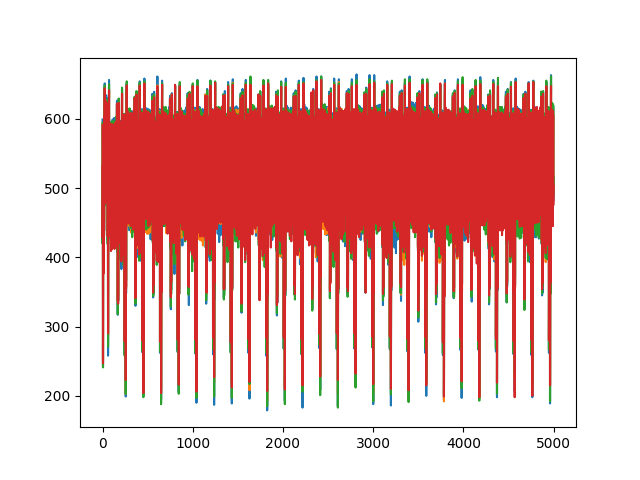

In [149]:

%matplotlib widget
# enable interactive plotting in the notebook

plt.figure()
plt.plot(project.traces[0].wave)
plt.plot(project.traces[1].wave)
plt.plot(project.traces[2].wave)
plt.plot(project.traces[3].wave)
plt.show()

In [12]:
#scope.dis()
#target.dis()